In [1]:
import os, sys, json, glob, copy, psutil, ast
from pprint import pprint
from time import time
import networkx as nx, numpy as np
from collections import defaultdict
from joblib import Parallel,delayed
from copy import deepcopy
import matplotlib.pyplot as plt

label_to_compressed_label_map = {}

get_int_node_label = lambda l: int(l.split('+')[-1])

In [2]:
def initial_relabel(g, node_label_attr_name='Label'):
    global label_to_compressed_label_map

    try:
        opfname = g+'.tmpg'
        g = nx.read_gexf(g)
    except:
        opfname = None
        pass

    nx.convert_node_labels_to_integers(g, first_label=0)  # this needs to be done for the initial interation only
    for node in g.nodes(): g.nodes[node]['relabel'] = {}

    for node in g.nodes():
        try:
            label = g.nodes[node][node_label_attr_name]
        except:
            # no node label referred in 'node_label_attr_name' is present, hence assigning an invalid compressd label
            g.nodes[node]['relabel'][0] = '0+0'
            continue

        if label not in label_to_compressed_label_map:
            compressed_label = len(label_to_compressed_label_map) + 1 #starts with 1 and incremented every time a new node label is seen
            label_to_compressed_label_map[label] = compressed_label #inster the new label to the label map
            g.nodes[node]['relabel'][0] = '0+' + str(compressed_label)
        else:
            g.nodes[node]['relabel'][0] = '0+' + str(label_to_compressed_label_map[label])

    if opfname:
        nx.write_gexf(g,opfname)
    else:
        return g
    

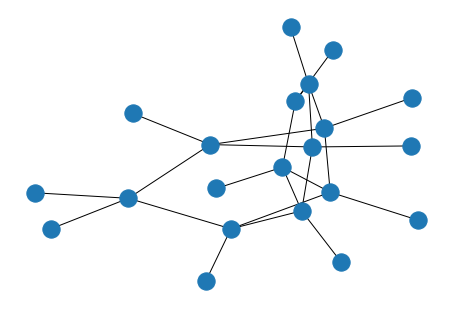

In [77]:
'''
node_label_attr_name='Label'
g = nx.read_gexf('/home/ipsita/BTP/graph2vec/data/kdd_datasets/ptc/1.gexf')
nx.convert_node_labels_to_integers(g, first_label=0)
for node in g.nodes(): 
    g.nodes[node]['relabel'] = {}
nx.draw(g)
'''

In [78]:
'''
for node in g.nodes():
        try:
            label = g.nodes[node][node_label_attr_name]
        except:
            # no node label referred in 'node_label_attr_name' is present, hence assigning an invalid compressd label
            g.nodes[node]['relabel'][0] = '0+0'
            continue

        if label not in label_to_compressed_label_map:
            compressed_label = len(label_to_compressed_label_map) + 1 #starts with 1 and incremented every time a new node label is seen
            label_to_compressed_label_map[label] = compressed_label #inster the new label to the label map
            g.nodes[node]['relabel'][0] = '0+' + str(compressed_label)
        else:
            g.nodes[node]['relabel'][0] = '0+' + str(label_to_compressed_label_map[label])

for node in g.nodes():
    print(g.nodes[node])

print(label_to_compressed_label_map)
'''

{'relabel': {0: '0+1'}, 'Label': '5', 'label': '11'}
{'relabel': {0: '0+2'}, 'Label': '22', 'label': '10'}
{'relabel': {0: '0+1'}, 'Label': '5', 'label': '13'}
{'relabel': {0: '0+2'}, 'Label': '22', 'label': '12'}
{'relabel': {0: '0+2'}, 'Label': '22', 'label': '15'}
{'relabel': {0: '0+1'}, 'Label': '5', 'label': '14'}
{'relabel': {0: '0+2'}, 'Label': '22', 'label': '17'}
{'relabel': {0: '0+1'}, 'Label': '5', 'label': '16'}
{'relabel': {0: '0+2'}, 'Label': '22', 'label': '19'}
{'relabel': {0: '0+1'}, 'Label': '5', 'label': '18'}
{'relabel': {0: '0+1'}, 'Label': '5', 'label': '1'}
{'relabel': {0: '0+2'}, 'Label': '22', 'label': '0'}
{'relabel': {0: '0+1'}, 'Label': '5', 'label': '3'}
{'relabel': {0: '0+2'}, 'Label': '22', 'label': '2'}
{'relabel': {0: '0+3'}, 'Label': '15', 'label': '5'}
{'relabel': {0: '0+2'}, 'Label': '22', 'label': '4'}
{'relabel': {0: '0+1'}, 'Label': '5', 'label': '7'}
{'relabel': {0: '0+2'}, 'Label': '22', 'label': '6'}
{'relabel': {0: '0+1'}, 'Label': '5', 'label

In [79]:
#nx.write_gexf(g,'/home/ipsita/BTP/graph2vec/1.gexf.tmpg')

In [80]:
'''
g = nx.read_gexf('/home/ipsita/BTP/graph2vec/1.gexf.tmpg')
for node in g.nodes():
    print(g.nodes[node])
'''

{'relabel': "{0: '0+1'}", 'Label': '5', 'label': '11'}
{'relabel': "{0: '0+2'}", 'Label': '22', 'label': '10'}
{'relabel': "{0: '0+1'}", 'Label': '5', 'label': '13'}
{'relabel': "{0: '0+2'}", 'Label': '22', 'label': '12'}
{'relabel': "{0: '0+2'}", 'Label': '22', 'label': '15'}
{'relabel': "{0: '0+1'}", 'Label': '5', 'label': '14'}
{'relabel': "{0: '0+2'}", 'Label': '22', 'label': '17'}
{'relabel': "{0: '0+1'}", 'Label': '5', 'label': '16'}
{'relabel': "{0: '0+2'}", 'Label': '22', 'label': '19'}
{'relabel': "{0: '0+1'}", 'Label': '5', 'label': '18'}
{'relabel': "{0: '0+1'}", 'Label': '5', 'label': '1'}
{'relabel': "{0: '0+2'}", 'Label': '22', 'label': '0'}
{'relabel': "{0: '0+1'}", 'Label': '5', 'label': '3'}
{'relabel': "{0: '0+2'}", 'Label': '22', 'label': '2'}
{'relabel': "{0: '0+3'}", 'Label': '15', 'label': '5'}
{'relabel': "{0: '0+2'}", 'Label': '22', 'label': '4'}
{'relabel': "{0: '0+1'}", 'Label': '5', 'label': '7'}
{'relabel': "{0: '0+2'}", 'Label': '22', 'label': '6'}
{'relabe

In [81]:
'''
new_g = deepcopy(g)
for n in g.nodes():
    new_g.nodes[n]['relabel'] = ast.literal_eval(g.nodes[n]['relabel'])
g = new_g

for node in g.nodes():
    print(g.nodes[node])
'''

{'relabel': {0: '0+1'}, 'Label': '5', 'label': '11'}
{'relabel': {0: '0+2'}, 'Label': '22', 'label': '10'}
{'relabel': {0: '0+1'}, 'Label': '5', 'label': '13'}
{'relabel': {0: '0+2'}, 'Label': '22', 'label': '12'}
{'relabel': {0: '0+2'}, 'Label': '22', 'label': '15'}
{'relabel': {0: '0+1'}, 'Label': '5', 'label': '14'}
{'relabel': {0: '0+2'}, 'Label': '22', 'label': '17'}
{'relabel': {0: '0+1'}, 'Label': '5', 'label': '16'}
{'relabel': {0: '0+2'}, 'Label': '22', 'label': '19'}
{'relabel': {0: '0+1'}, 'Label': '5', 'label': '18'}
{'relabel': {0: '0+1'}, 'Label': '5', 'label': '1'}
{'relabel': {0: '0+2'}, 'Label': '22', 'label': '0'}
{'relabel': {0: '0+1'}, 'Label': '5', 'label': '3'}
{'relabel': {0: '0+2'}, 'Label': '22', 'label': '2'}
{'relabel': {0: '0+3'}, 'Label': '15', 'label': '5'}
{'relabel': {0: '0+2'}, 'Label': '22', 'label': '4'}
{'relabel': {0: '0+1'}, 'Label': '5', 'label': '7'}
{'relabel': {0: '0+2'}, 'Label': '22', 'label': '6'}
{'relabel': {0: '0+1'}, 'Label': '5', 'label

In [83]:
'''
# simulate for first iteration
it = 1
prev_iter = it - 1

for node in g.nodes():
    
    print('for node',g.nodes[node]['label'])
    prev_iter_node_label = get_int_node_label(g.nodes[node]['relabel'][prev_iter])
    
    node_label = [prev_iter_node_label]
    #print('prev iter label =',node_label)
    
    neighbors = list(nx.all_neighbors(g, node))
    #print('neighbours are', neighbors)
    
    neighborhood_label = sorted([get_int_node_label(g.nodes[nei]['relabel'][prev_iter]) for nei in neighbors])
    #print('neighbour lables are',neighborhood_label)
    
    node_neighborhood_label = tuple(node_label + neighborhood_label)
    print('tuple is', node_neighborhood_label)
    
    if node_neighborhood_label not in label_to_compressed_label_map:
        compressed_label = len(label_to_compressed_label_map) + 1
        label_to_compressed_label_map[node_neighborhood_label] = compressed_label
        g.nodes[node]['relabel'][it] = str(it) + '+' + str(compressed_label)
    else:
        g.nodes[node]['relabel'][it] = str(it) + '+' + str(label_to_compressed_label_map[node_neighborhood_label])
    

print(label_to_compressed_label_map)
for node in g.nodes():
    print(g.nodes[node])
'''

for node 11
tuple is (1, 2)
for node 10
tuple is (2, 1, 2, 2, 2)
for node 13
tuple is (1, 2)
for node 12
tuple is (2, 1, 1, 2, 2)
for node 15
tuple is (2, 1, 2, 2, 2)
for node 14
tuple is (1, 2)
for node 17
tuple is (2, 1, 2, 2, 2)
for node 16
tuple is (1, 2)
for node 19
tuple is (2, 1, 2, 2, 2)
for node 18
tuple is (1, 2)
for node 1
tuple is (1, 2)
for node 0
tuple is (2, 1, 2, 2, 2)
for node 3
tuple is (1, 2)
for node 2
tuple is (2, 1, 2, 2, 2)
for node 5
tuple is (3, 2)
for node 4
tuple is (2, 2, 2, 3)
for node 7
tuple is (1, 2)
for node 6
tuple is (2, 1, 2, 2, 2)
for node 9
tuple is (1, 2)
for node 20
tuple is (1, 2)
for node 8
tuple is (2, 1, 2, 2, 2)
{'5': 1, '22': 2, '15': 3, (1, 2): 4, (2, 1, 2, 2, 2): 5, (2, 1, 1, 2, 2): 6, (3, 2): 7, (2, 2, 2, 3): 8}
{'relabel': {0: '0+1', 1: '1+4'}, 'Label': '5', 'label': '11'}
{'relabel': {0: '0+2', 1: '1+5'}, 'Label': '22', 'label': '10'}
{'relabel': {0: '0+1', 1: '1+4'}, 'Label': '5', 'label': '13'}
{'relabel': {0: '0+2', 1: '1+6'}, 'Labe

In [84]:
#nx.write_gexf(g,'/home/ipsita/BTP/graph2vec/1.gexf.tmpg')

In [3]:
def wl_relabel(g, it):
    global label_to_compressed_label_map

    try:
        opfname = g+'.tmpg'
        g = nx.read_gexf(g+'.tmpg')
        new_g = deepcopy(g)
        for n in g.nodes():
            new_g.nodes[n]['relabel'] = ast.literal_eval(g.nodes[n]['relabel'])
        g = new_g
    except:
        opfname = None
        pass

    prev_iter = it - 1
    for node in g.nodes():
        prev_iter_node_label = get_int_node_label(g.nodes[node]['relabel'][prev_iter])
        node_label = [prev_iter_node_label]
        neighbors = list(nx.all_neighbors(g, node))
        neighborhood_label = sorted([get_int_node_label(g.nodes[nei]['relabel'][prev_iter]) for nei in neighbors])
        node_neighborhood_label = tuple(node_label + neighborhood_label)
        if node_neighborhood_label not in label_to_compressed_label_map:
            compressed_label = len(label_to_compressed_label_map) + 1
            label_to_compressed_label_map[node_neighborhood_label] = compressed_label
            g.nodes[node]['relabel'][it] = str(it) + '+' + str(compressed_label)
        else:
            g.nodes[node]['relabel'][it] = str(it) + '+' + str(label_to_compressed_label_map[node_neighborhood_label])

    if opfname:
        nx.write_gexf(g,opfname)
    else:
        return g
    
    

In [ ]:
'''
g = nx.read_gexf('/home/ipsita/BTP/graph2vec/1.gexf.tmpg')
new_g = deepcopy(g)
for n in g.nodes():
    del new_g.nodes[n]['relabel']
    new_g.nodes[n]['relabel'] = ast.literal_eval(g.nodes[n]['relabel'])
g = new_g
'''

In [88]:
#for node in g.nodes():
#    print(g.nodes[node])

{'Label': '5', 'label': '11', 'relabel': {0: '0+1', 1: '1+4'}}
{'Label': '22', 'label': '10', 'relabel': {0: '0+2', 1: '1+5'}}
{'Label': '5', 'label': '13', 'relabel': {0: '0+1', 1: '1+4'}}
{'Label': '22', 'label': '12', 'relabel': {0: '0+2', 1: '1+6'}}
{'Label': '22', 'label': '15', 'relabel': {0: '0+2', 1: '1+5'}}
{'Label': '5', 'label': '14', 'relabel': {0: '0+1', 1: '1+4'}}
{'Label': '22', 'label': '17', 'relabel': {0: '0+2', 1: '1+5'}}
{'Label': '5', 'label': '16', 'relabel': {0: '0+1', 1: '1+4'}}
{'Label': '22', 'label': '19', 'relabel': {0: '0+2', 1: '1+5'}}
{'Label': '5', 'label': '18', 'relabel': {0: '0+1', 1: '1+4'}}
{'Label': '5', 'label': '1', 'relabel': {0: '0+1', 1: '1+4'}}
{'Label': '22', 'label': '0', 'relabel': {0: '0+2', 1: '1+5'}}
{'Label': '5', 'label': '3', 'relabel': {0: '0+1', 1: '1+4'}}
{'Label': '22', 'label': '2', 'relabel': {0: '0+2', 1: '1+5'}}
{'Label': '15', 'label': '5', 'relabel': {0: '0+3', 1: '1+7'}}
{'Label': '22', 'label': '4', 'relabel': {0: '0+2', 

In [94]:
'''
max_h = 1

for n,d in g.nodes(data=True):
    
    print("n =", n)
    
    for i in range(0, max_h+1):
        
        print("i =", i)
        try:
            center = d['relabel'][i]
        except:
            continue
            
        neis_labels_prev_deg = []
        neis_labels_next_deg = []

        if i != 0:
            neis_labels_prev_deg = list(set([g.nodes[nei]['relabel'][i-1] for nei in nx.all_neighbors(g, n)]))
            neis_labels_prev_deg.sort()
        print("neis_labels_prev_deg =", neis_labels_prev_deg)
        
        NeisLabelsSameDeg = list(set([g.nodes[nei]['relabel'][i] for nei in nx.all_neighbors(g,n)]))
        print("NeilsLabelSameDeg =", NeisLabelsSameDeg)
        
        if i != max_h:
            neis_labels_next_deg = list(set([g.nodes[nei]['relabel'][i+1] for nei in nx.all_neighbors(g,n)]))
            neis_labels_next_deg.sort()
        print("neis_labels_next_deg =", neis_labels_next_deg)

        nei_list = NeisLabelsSameDeg + neis_labels_prev_deg + neis_labels_next_deg
        nei_list = ' '.join (nei_list)

        sentence = center + ' ' + nei_list
        #print>>fh, sentence
        print(sentence)
        
    break
'''

n = 11
i = 0
neis_labels_prev_deg = []
NeilsLabelSameDeg = ['0+2']
neis_labels_next_deg = ['1+5']
0+1 0+2 1+5
i = 1
neis_labels_prev_deg = ['0+2']
NeilsLabelSameDeg = ['1+5']
neis_labels_next_deg = []
1+4 1+5 0+2


In [4]:
def dump_sg2vec_str (fname,max_h,g=None):
    if not g:
        g = nx.read_gexf(fname+'.tmpg')
        new_g = deepcopy(g)
        for n in g.nodes():
            del new_g.nodes[n]['relabel']
            new_g.nodes[n]['relabel'] = ast.literal_eval(g.nodes[n]['relabel'])
        g = new_g

    opfname = fname + '.g2v' + str(max_h)

    if os.path.isfile(opfname):
        return

    with open(opfname,'w') as fh:
        for n,d in g.nodes(data=True):
            for i in range(0, max_h+1):
                try:
                    center = d['relabel'][i]
                except:
                    continue
                neis_labels_prev_deg = []
                neis_labels_next_deg = []

                if i != 0:
                    neis_labels_prev_deg = list(set([g.nodes[nei]['relabel'][i-1] for nei in nx.all_neighbors(g, n)]))
                    neis_labels_prev_deg.sort()
                NeisLabelsSameDeg = list(set([g.nodes[nei]['relabel'][i] for nei in nx.all_neighbors(g,n)]))
                if i != max_h:
                    neis_labels_next_deg = list(set([g.nodes[nei]['relabel'][i+1] for nei in nx.all_neighbors(g,n)]))
                    neis_labels_next_deg.sort()

                nei_list = NeisLabelsSameDeg + neis_labels_prev_deg + neis_labels_next_deg
                nei_list = ' '.join (nei_list)

                sentence = center + ' ' + nei_list
                print(sentence, file=fh)
                #print>>fh, sentence

#     if os.path.isfile(fname+'.tmpg'):######################## REMOVED THIS ###################
#         os.system('rm '+fname+'.tmpg')
        

In [109]:
'''
ip_folder = '/home/ipsita/BTP/graph2vec/data/kdd_datasets/ptc'
max_h = 3
fnames = sorted(glob.glob(os.path.join(ip_folder,'*gexf')))#[:100]
print(len(fnames))
graphs = [nx.read_gexf(fname) for fname in fnames]

t0 = time()
graphs = [initial_relabel(g,node_label_attr_name) for g in graphs]
'''

344


In [115]:
'''
g = graphs[0]
for it in range(1, max_h + 1):
    print('it=',it)
    #t0 = time()
    label_to_compressed_label_map = {}
    #graphs = [wl_relabel(g, it) for g in graphs]
    wl_relabel(g, it)
    print(label_to_compressed_label_map)
'''

it= 1
{(1, 2, 2, 2, 3): 1, (2, 1): 2, (3, 1): 3}
it= 2
{(1, 2, 2, 2, 3): 1, (2, 1): 2, (3, 1): 3}
it= 3
{(1, 2, 2, 2, 3): 1, (2, 1): 2, (3, 1): 3}


In [5]:
def wlk_relabel_and_dump_memory_version(fnames,max_h,node_label_attr_name='Label'):
    global label_to_compressed_label_map
    
    t0 = time.time()
    graphs = [nx.read_gexf(fname) for fname in fnames]
    print('loaded all graphs in',round(time.time() - t0, 2), 'sec')

    t0 = time.time()
    graphs = [initial_relabel(g,node_label_attr_name) for g in graphs]
    print('initial relabeling done in', round(time.time() - t0, 2) ,'sec')

    for it in range(1, (max_h + 1)):
        t0 = time.time()
        label_to_compressed_label_map = {}
        graphs = [wl_relabel(g, it) for g in graphs]
        print ('WL iteration {} done in {} sec.'.format(it, round(time.time() - t0, 2)))
        print ('num of WL rooted subgraphs in iter',it,'is', len(label_to_compressed_label_map))

    t0 = time.time()
    for fname, g in zip(fnames, graphs):
        dump_sg2vec_str(fname, max_h, g)
    print('dumped sg2vec sentences in', round(time.time() - t0, 2))